# Team Benchmark

**Authors:** Marissa Nicole Esteban, Gabe Krishnadasan, Diana Montoya-Herrera, Gabe Seidl, Madeleine Woo

**Date:** 10/5/2023

### Wave Height

#### Dataset: https://www.kaggle.com/code/shaltaf/the-prediction-of-significant-wave-height-hs/notebook 

## Table of Contents:
* [Data Importing and Pre-processing](#data-importing)
* [Data Analysis and Visualization](#data-vis)
* [Data Analytics](#data-analytics)

In [176]:
pip install seebuoy

Note: you may need to restart the kernel to use updated packages.


In [177]:
from seebuoy import NDBC

ndbc = NDBC()

# Information on NDBC's ~1800 buoys and gliders
wave_df = ndbc.stations()

# list all available data for all buoys
df_data = ndbc.available_data()

# Get info on NY Harbor Buoy
station_id = "44065"
ny_buoy = ndbc.get_data(station_id)


## Data Importing and Pre-processing <a class="anchor" id="data-importing"></a>

In [178]:
# import libraries needed
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [179]:
# read in file
# wave_df = pd.read_csv('Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv')

In [180]:
# num rows and columns
ny_buoy.shape

(6530, 14)

In [181]:
# num of categorical variables
cat_count = 0
for dtype in ny_buoy.dtypes:
    if dtype == 'object':
        cat_count = cat_count + 1

In [182]:
print('# of categorical variables:',cat_count)
print('# of continuous variables:',ny_buoy.shape[1] - cat_count - 1) # subtract and extra column as 1 column is an ID column

# of categorical variables: 0
# of continuous variables: 13


In [183]:
# How I identified a buoy to investigate
ny_buoys = wave_df[wave_df['closest_state'] == 'New York']
ny_buoys.head()
# use 44065 because it's off the coast and not in a lake or something

,station_id,owner,ttype,hull,name,payload,location,timezone,forecast,note,lat_lon,lat,lon,closest_city,closest_state,ownercode,ownername,countrycode
322,44022,Y,Moored Buoy,NaN,Execution Rocks,NaN,"40.883 N 73.728 W (40&#176;53'0"" N 73&#176;43'...",E,FZUS51.KOKX,NaN,40.883 N 73.728 W,40.883,-73.728,New Rochelle,New York,Y,MYSOUND,US
325,44025,N,3-meter foam buoy,3DV24,"LONG ISLAND - 30 NM South of Islip, NY",SCOOP payload,"40.251 N 73.164 W (40&#176;15'3"" N 73&#176;9'5...",E,FZNT21.KWBC FZUS51.KOKX,Right whales are active off NY from November t...,40.251 N 73.164 W,40.251,-73.164,Freeport,New York,N,NDBC,US
358,44065,N,3-meter foam buoy,3DV12,New York Harbor Entrance - 15 NM SE of Breezy ...,SCOOP payload,"40.369 N 73.703 W (40&#176;22'10"" N 73&#176;42...",E,FZUS51.KOKX FZUS51.KPHI,Right whales are active off NY from November t...,40.369 N 73.703 W,40.369,-73.703,Valley Stream,New York,N,NDBC,US
359,44066,N,3-meter foam buoy,3DV46,"Texas Tower #4 - 75 NM East of Long Beach, NJ",SCOOP payload,"39.618 N 72.644 W (39&#176;37'6"" N 72&#176;38'...",E,FZNT22.KWBC,</p>Right whales are active off NJ from Novemb...,39.618 N 72.644 W,39.618,-72.644,Freeport,New York,N,NDBC,US
362,44069,ST,Buoy,NaN,Great South Bay,NaN,"40.699 N 73.087 W (40&#176;41'55"" N 73&#176;5'...",E,FZUS51.KOKX,NaN,40.699 N 73.087 W,40.699,-73.087,Freeport,New York,ST,Stony Brook University,US


### Handling missing data

In [184]:

nan_count = ny_buoy.isna().sum()
nan_count

wind_direction         6530
wind_speed               31
wind_gust                31
wave_height            3279
dominant_period        4371
average_period         3282
mean_wave_direction    3282
pressure                 29
air_temp               6530
water_temp              188
dewpoint               6530
visibility             6530
pressure_tendency      5450
tide                   6530
dtype: int64

In [185]:
# missing data
# it appears there is a lot of missing data
total_na = ny_buoy.isnull().sum().sort_values(ascending=False)
total_rows = ny_buoy.isnull().count()
percent = (ny_buoy.isnull().sum()/ny_buoy.isnull().count()).sort_values(ascending=False) * 100
missing_data = pd.concat([total_na, total_rows, percent], axis=1, keys=['Total NA', 'Total Rows', 'Percent'])
missing_data

,Total NA,Total Rows,Percent
wind_direction,6530,6530,100.000000
air_temp,6530,6530,100.000000
dewpoint,6530,6530,100.000000
visibility,6530,6530,100.000000
tide,6530,6530,100.000000
pressure_tendency,5450,6530,83.460949
dominant_period,4371,6530,66.937213
average_period,3282,6530,50.260337
mean_wave_direction,3282,6530,50.260337
wave_height,3279,6530,50.214395


In [186]:
ny_buoy

,wind_direction,wind_speed,wind_gust,wave_height,dominant_period,average_period,mean_wave_direction,pressure,air_temp,water_temp,dewpoint,visibility,pressure_tendency,tide
date,,,,,,,,,,,,,,
2023-09-28 00:00:00,NaN,8.0,10.0,NaN,NaN,NaN,NaN,1024.2,NaN,19.2,NaN,NaN,0.3,NaN
2023-09-28 00:10:00,NaN,8.0,10.0,1.8,NaN,5.5,92.0,1024.3,NaN,19.2,NaN,NaN,NaN,NaN
2023-09-28 00:20:00,NaN,8.0,10.0,1.8,7.0,5.5,92.0,1024.3,NaN,19.2,NaN,NaN,NaN,NaN
2023-09-28 00:30:00,NaN,8.0,10.0,NaN,NaN,NaN,NaN,1024.2,NaN,19.2,NaN,NaN,NaN,NaN
2023-09-28 00:40:00,NaN,8.0,10.0,1.7,NaN,5.5,102.0,1024.3,NaN,19.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-12 19:30:00,NaN,3.0,5.0,NaN,NaN,NaN,NaN,1029.7,NaN,13.8,NaN,NaN,NaN,NaN
2023-11-12 19:40:00,NaN,2.0,4.0,NaN,NaN,NaN,NaN,1029.5,NaN,13.8,NaN,NaN,NaN,NaN
2023-11-12 19:50:00,NaN,3.0,5.0,0.7,5.0,4.1,84.0,1029.4,NaN,13.8,NaN,NaN,NaN,NaN


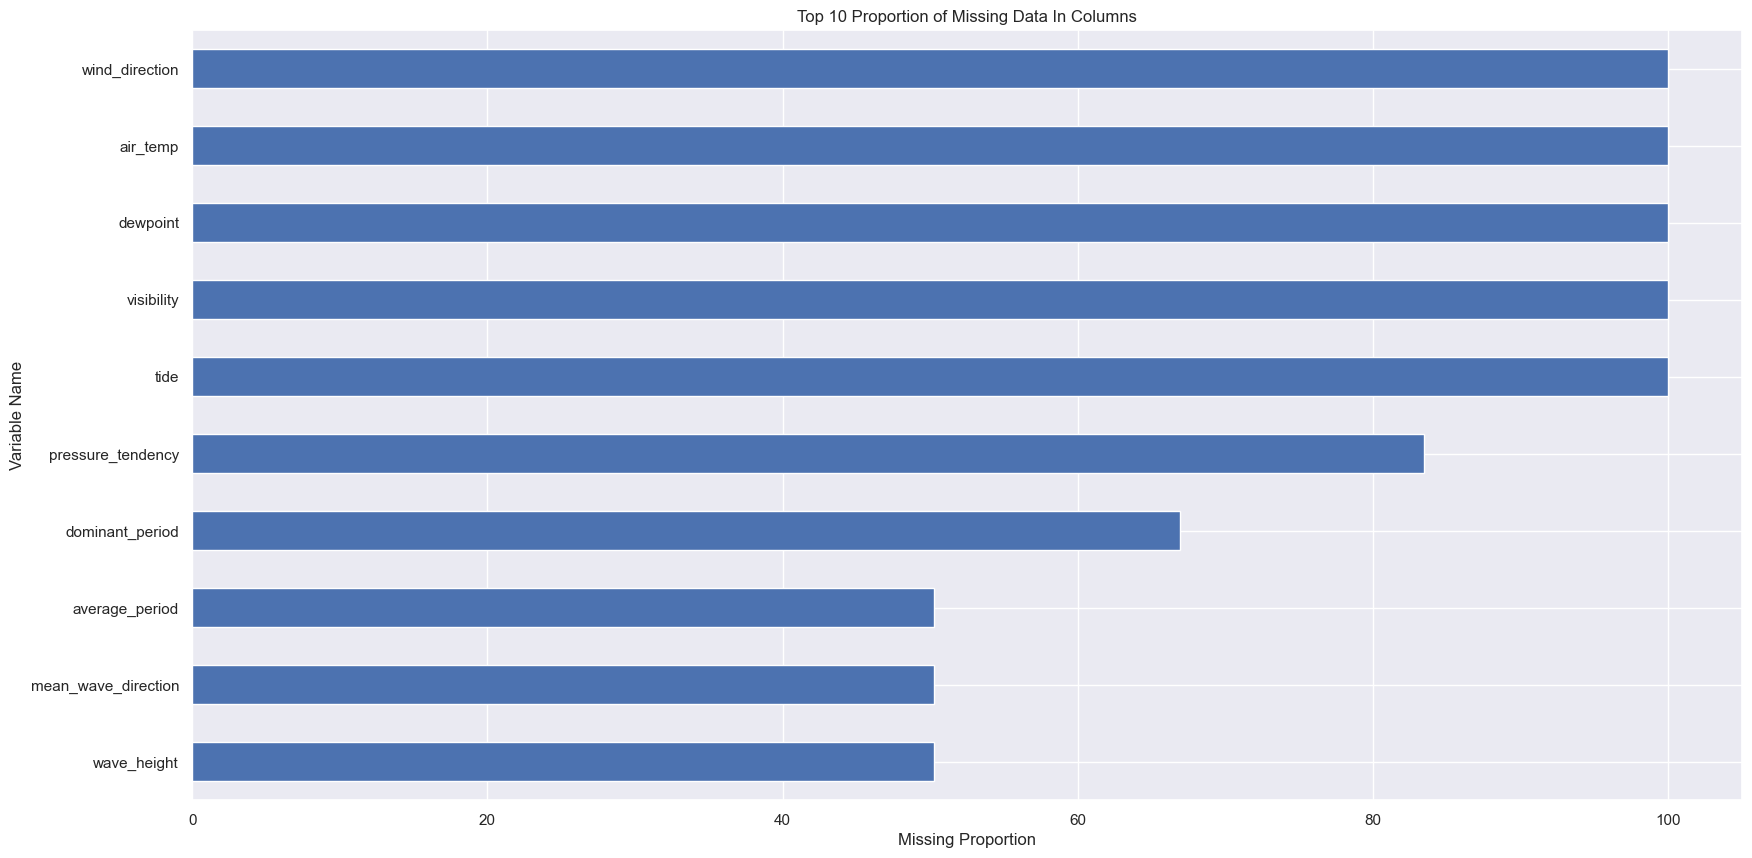

In [187]:
missing_data['Percent'].head(10).plot(kind='barh', figsize = (20,10)).invert_yaxis() # top 10 missing columns
plt.xlabel("Missing Proportion")
plt.ylabel("Variable Name")
plt.title("Top 10 Proportion of Missing Data In Columns")
plt.show()

In [188]:
# handle missing data

# Dropping the columns that have no data
ny_buoy["wind_direction"] = ny_buoy["wind_direction"].fillna(0)
ny_buoy["air_temp"] = ny_buoy["air_temp"].fillna(0)
ny_buoy["dewpoint"] = ny_buoy["dewpoint"].fillna(0)
ny_buoy["visibility"] = ny_buoy["visibility"].fillna(0)
ny_buoy["tide"] = ny_buoy["tide"].fillna(0)
ny_buoy["pressure_tendency"] = ny_buoy["pressure_tendency"].fillna(0)

# Replace missing data with mode
ny_buoy['dominant_period'] = ny_buoy['dominant_period'].fillna(ny_buoy['dominant_period'].mode()[0])
ny_buoy['average_period'] = ny_buoy['average_period'].fillna(ny_buoy['average_period'].mode()[0])
ny_buoy['mean_wave_direction'] = ny_buoy['mean_wave_direction'].fillna(ny_buoy['mean_wave_direction'].mode()[0])
ny_buoy['wave_height'] = ny_buoy['wave_height'].fillna(ny_buoy['wave_height'].mode()[0])
ny_buoy['water_temp'] = ny_buoy['water_temp'].fillna(ny_buoy['water_temp'].mode()[0])
ny_buoy['wind_speed'] = ny_buoy['wind_speed'].fillna(ny_buoy['wind_speed'].mode()[0])
ny_buoy['wind_gust'] = ny_buoy['wind_gust'].fillna(ny_buoy['wind_gust'].mode()[0])
ny_buoy['pressure'] = ny_buoy['pressure'].fillna(ny_buoy['pressure'].mode()[0])

In [189]:
#Check remaining missing values if any 
all_data_na = (ny_buoy.isnull().sum() / len(ny_buoy)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


### Handling Outliers

#### Target Variable

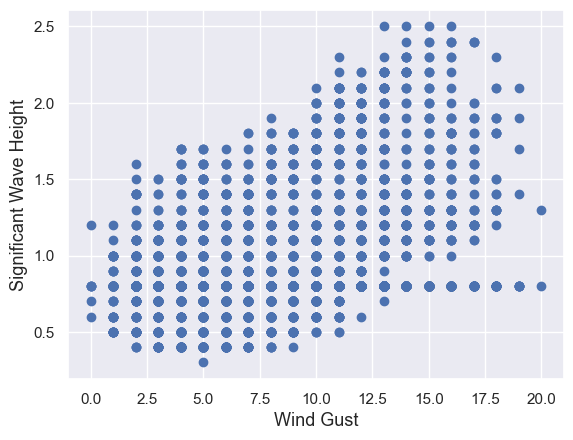

In [190]:
fig, ax = plt.subplots()
ax.scatter(x = ny_buoy['wind_gust'], y = ny_buoy['wave_height'])
plt.ylabel('Significant Wave Height', fontsize=13)
plt.xlabel('Wind Gust', fontsize=13)
plt.show()

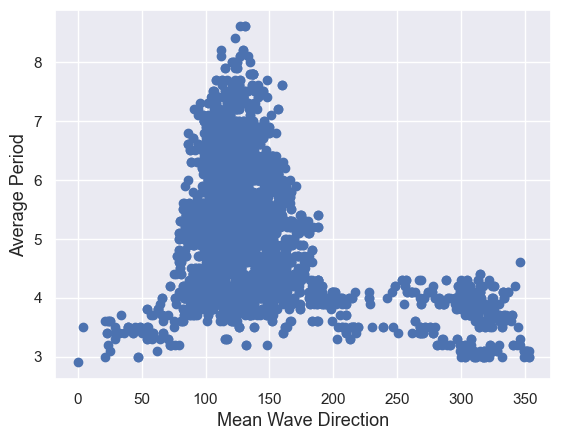

In [191]:
fig, ax = plt.subplots()
ax.scatter(x = ny_buoy['mean_wave_direction'], y = ny_buoy['average_period'],)
plt.ylabel('Average Period', fontsize=13)
plt.xlabel('Mean Wave Direction', fontsize=13)
plt.show()

In [192]:
# Remove non finite values
ny_buoy = ny_buoy[np.isfinite(ny_buoy['wave_height'])]


 mu = 0.63 and sigma = 0.15



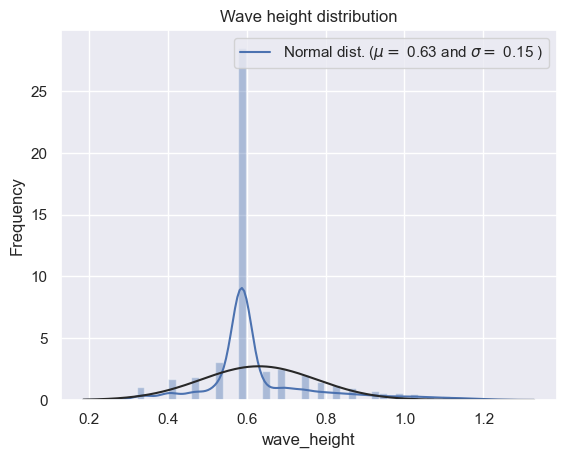

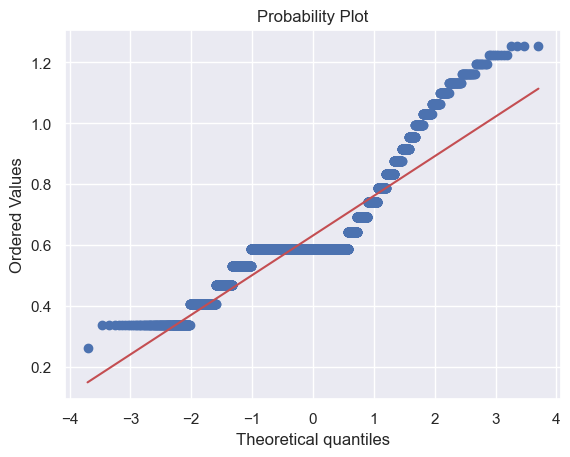

In [193]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
ny_buoy["wave_height"] = np.log1p(ny_buoy["wave_height"])

# Check the new distribution 
sns.distplot(ny_buoy['wave_height'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(ny_buoy['wave_height'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Wave height distribution')

# Get also the QQ-plot
fig = plt.figure()
res = probplot(ny_buoy['wave_height'], plot=plt)
plt.show()


 mu = 1.70 and sigma = 0.16



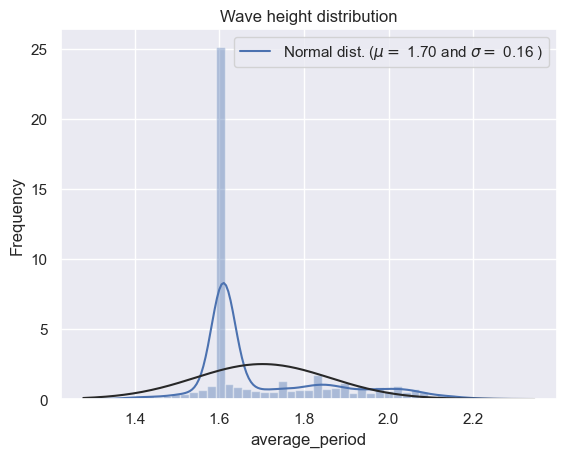

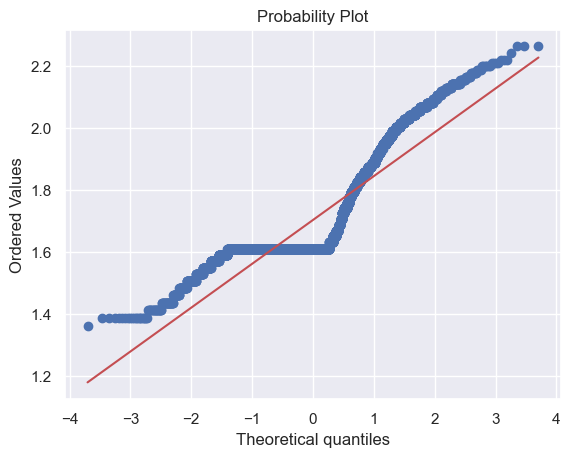

In [194]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
ny_buoy["average_period"] = np.log1p(ny_buoy["average_period"])

# Check the new distribution 
sns.distplot(ny_buoy['average_period'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(ny_buoy['average_period'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Wave height distribution')

# Get also the QQ-plot
fig = plt.figure()
res = probplot(ny_buoy['average_period'], plot=plt)
plt.show()

## Data Analysis and Visualization <a class="anchor" id="data-vis"></a>

In [195]:
from sklearn.preprocessing import LabelEncoder

Target Variable Scatterplots

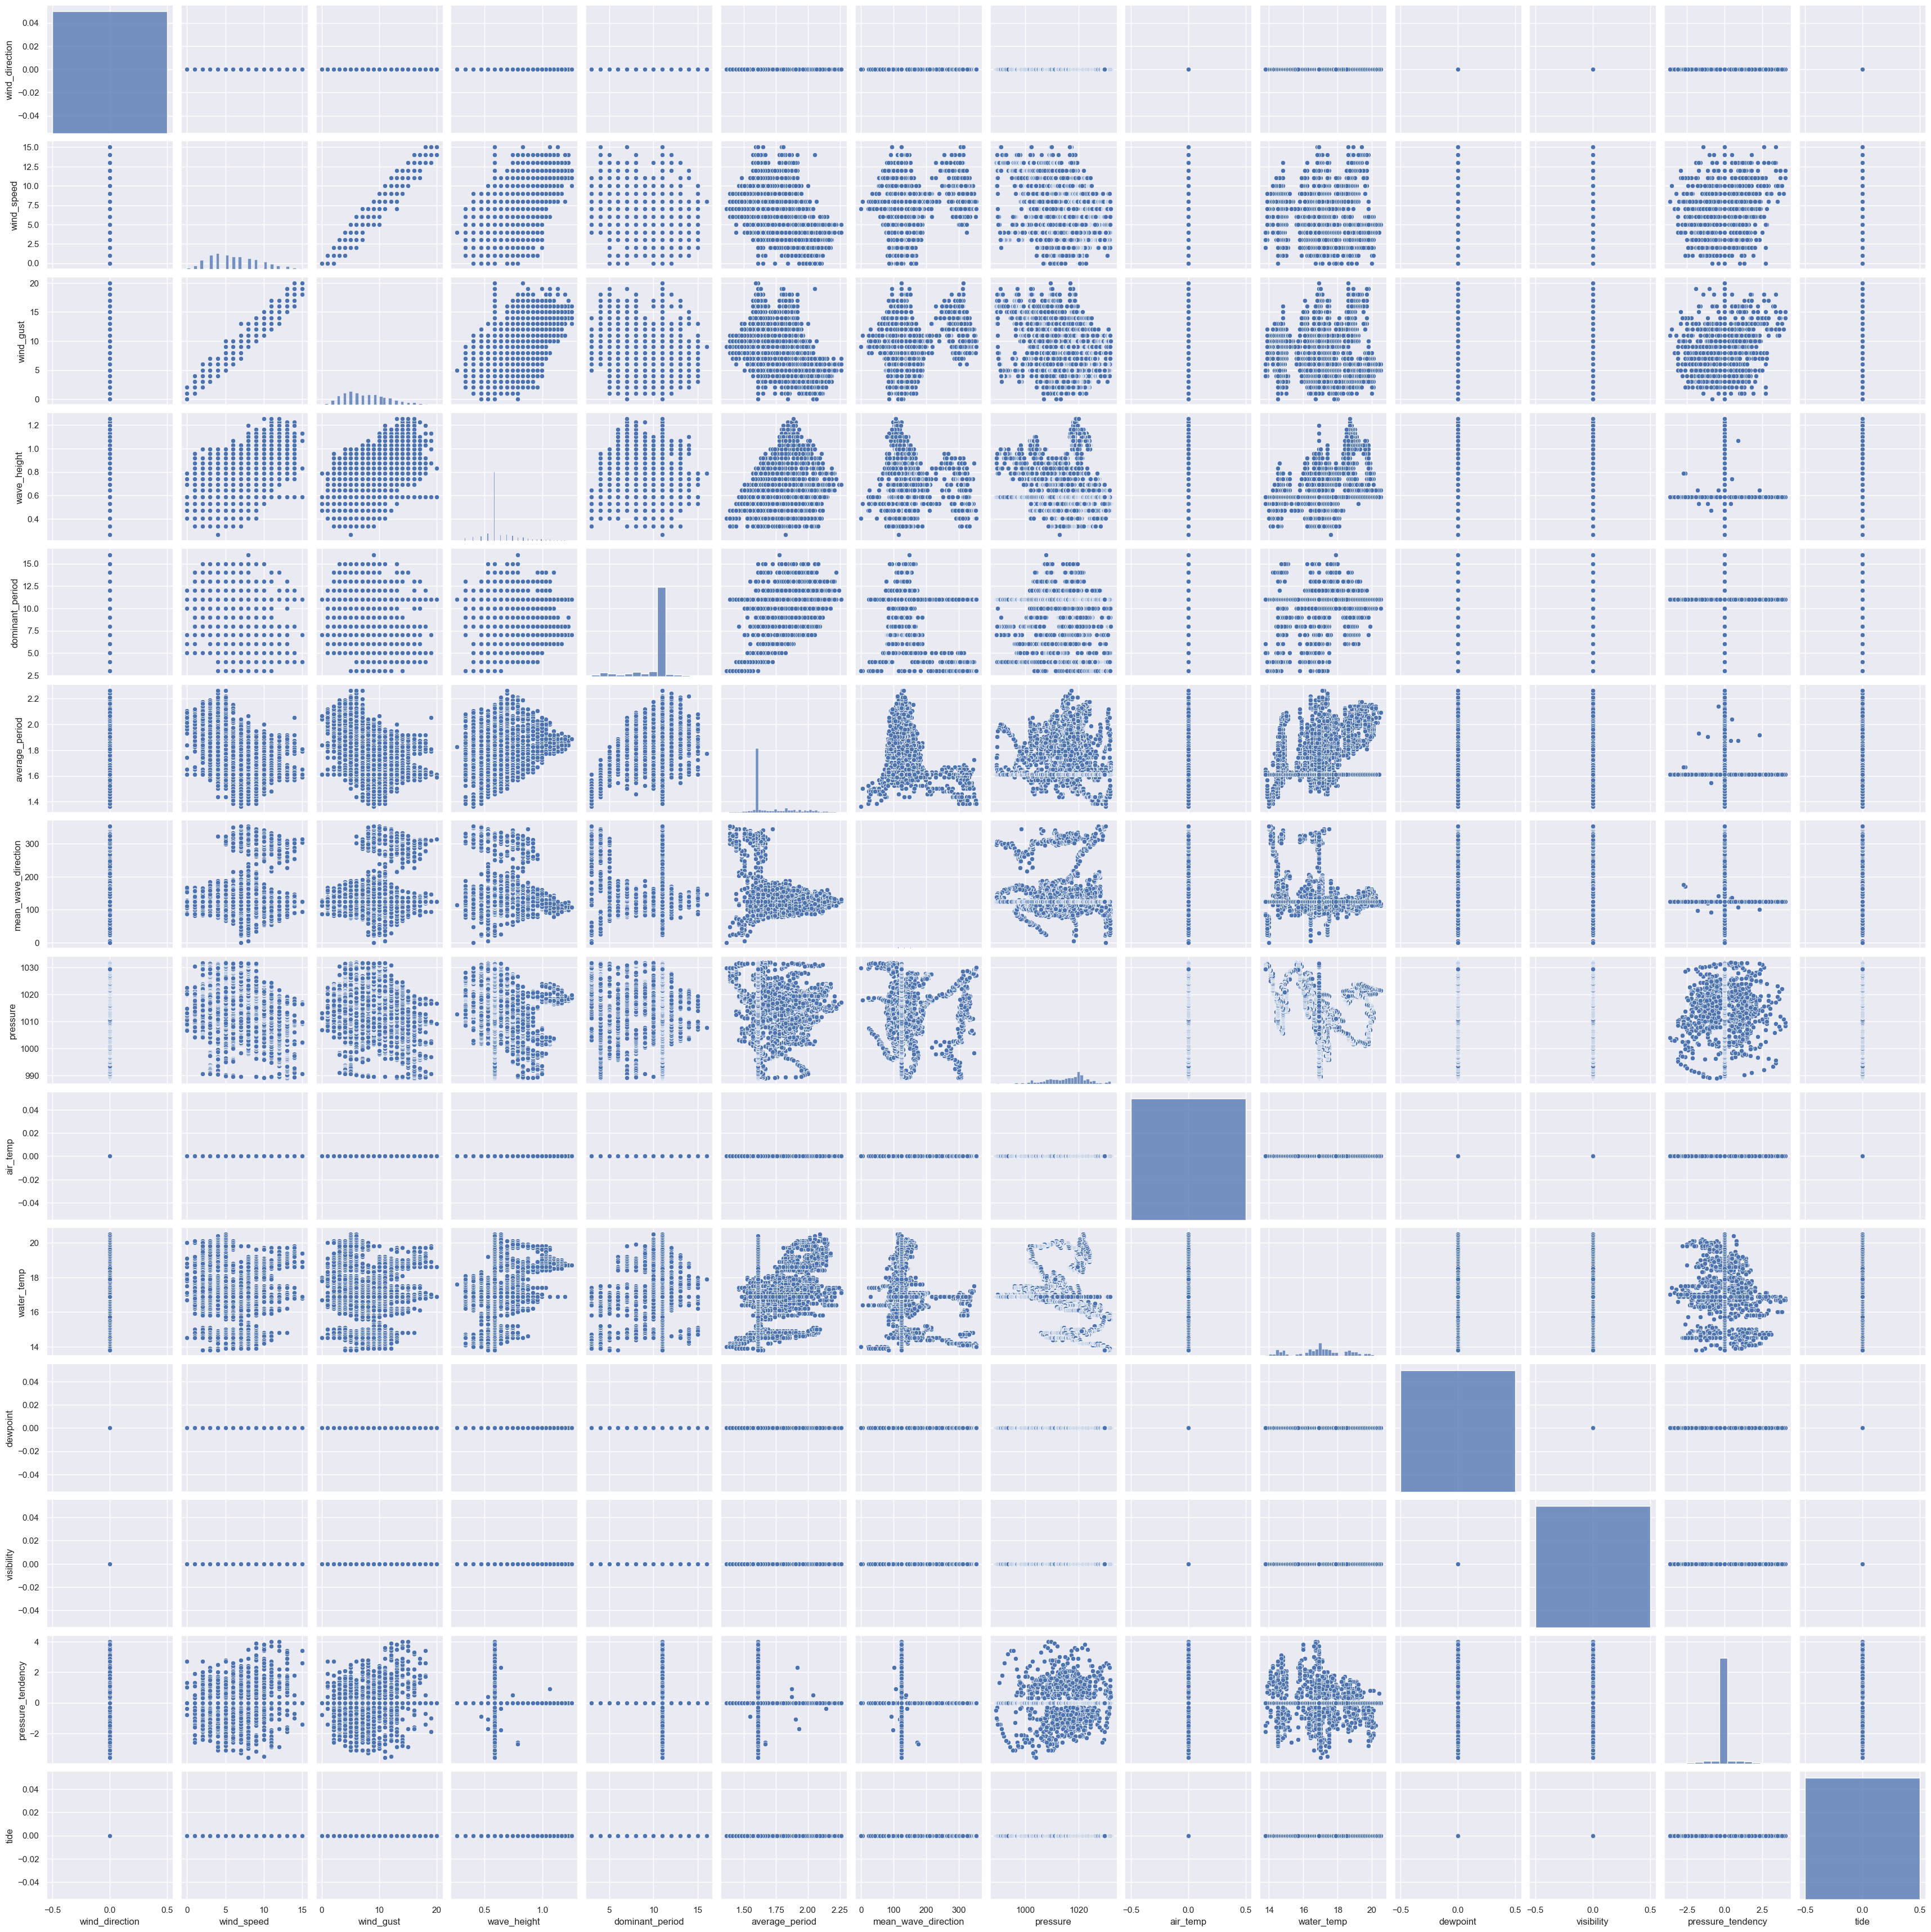

In [196]:
# scatterplot
sns.set()
cols = ['wind_direction', 'wind_speed', 'wind_gust', 'wave_height', 
        'dominant_period', 'average_period', 'mean_wave_direction', 
        'pressure', 'air_temp', 'water_temp', 'dewpoint', 'visibility',
        'pressure_tendency', 'tide']
sns.pairplot(ny_buoy[cols], size = 2.5)
plt.show();

Correlation Matrix

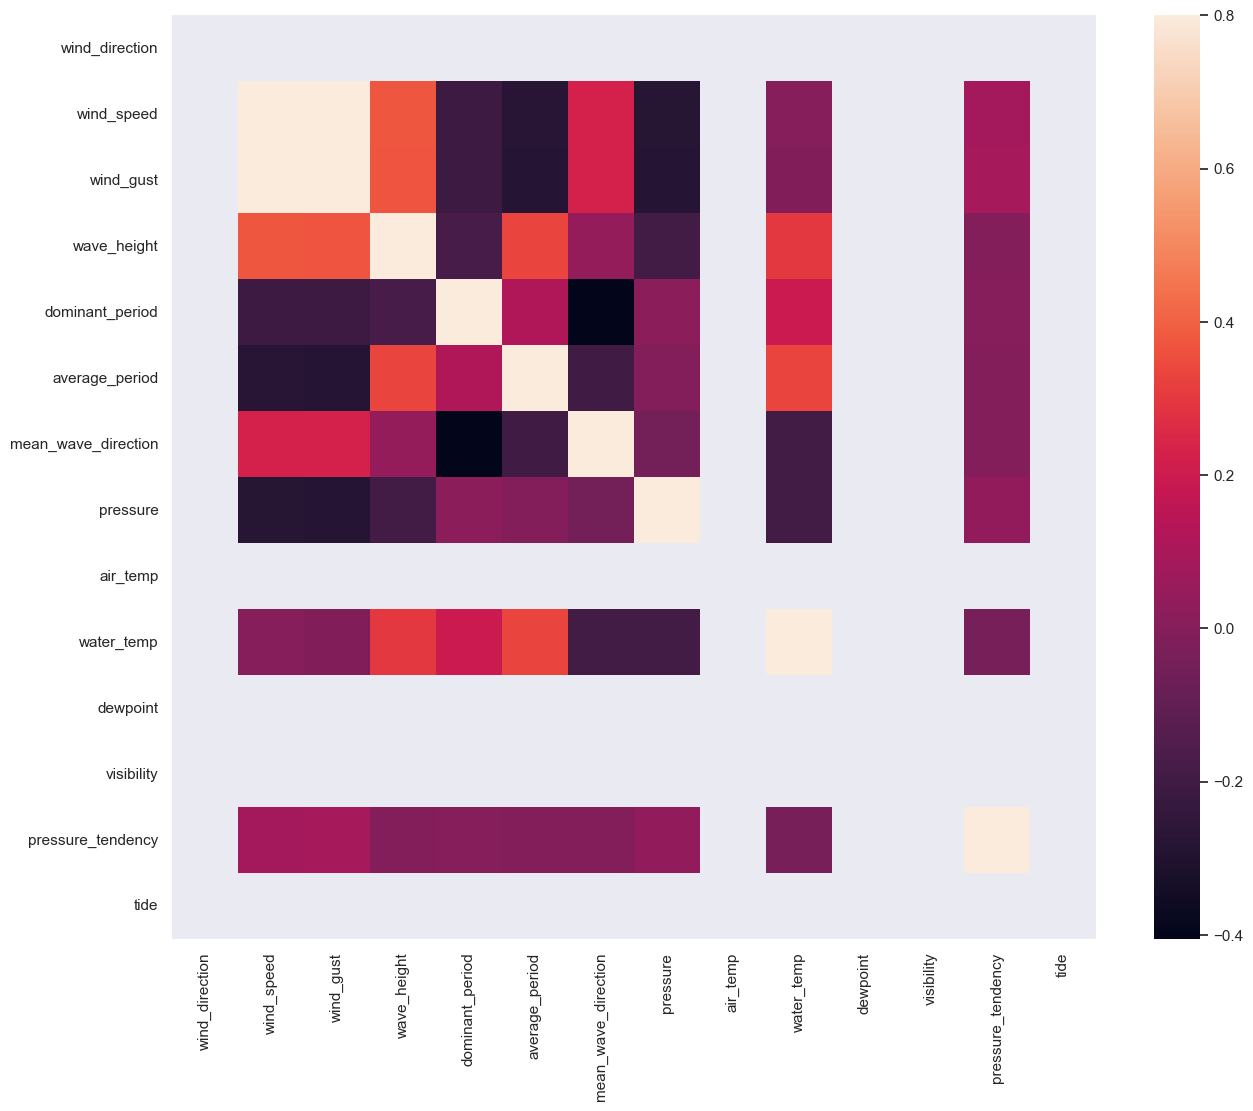

In [197]:
# Correlation map to see how conditions are correlated with wave height and average period
corrmat = ny_buoy.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

In [198]:
# TODO: Here, we would change continuous variables to categorical variables if needed.
# For this example, we don't need to do this.

#### Label encode categorical variables

In [199]:
# We only have one categorical variable, so we won't be doing this step at this point

## Data Analytics <a class="anchor" id="data-analytics"></a>

In [200]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb

In [201]:
# return a list containing all the column names in wave_df except for 'Hs'.
# aka isolating our dependent variable: avg wave height. 
train_df = ny_buoy[ny_buoy.columns.difference(['wave_height', 'average_period'])]
train_df.head()

,air_temp,dewpoint,dominant_period,mean_wave_direction,pressure,pressure_tendency,tide,visibility,water_temp,wind_direction,wind_gust,wind_speed
date,,,,,,,,,,,,
2023-09-28 00:00:00,0.0,0.0,11.0,124.0,1024.2,0.3,0.0,0.0,19.2,0.0,10.0,8.0
2023-09-28 00:10:00,0.0,0.0,11.0,92.0,1024.3,0.0,0.0,0.0,19.2,0.0,10.0,8.0
2023-09-28 00:20:00,0.0,0.0,7.0,92.0,1024.3,0.0,0.0,0.0,19.2,0.0,10.0,8.0
2023-09-28 00:30:00,0.0,0.0,11.0,124.0,1024.2,0.0,0.0,0.0,19.2,0.0,10.0,8.0
2023-09-28 00:40:00,0.0,0.0,11.0,102.0,1024.3,0.0,0.0,0.0,19.2,0.0,10.0,8.0


In [202]:
# Validation function for wave height
n_folds = 5

def rmse_cv(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse = np.sqrt(-cross_val_score(model, train_df, ny_buoy.wave_height, scoring="neg_mean_squared_error", cv = kf))
    return rmse

In [203]:
lr_w_int = LinearRegression()
lr_no_int = LinearRegression(fit_intercept=False)

In [204]:
neigh = KNeighborsRegressor(n_neighbors=10)

In [205]:
rf = RandomForestRegressor(n_estimators=100)

In [206]:
dt = DecisionTreeRegressor(max_depth = 10)

In [207]:
model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)

In [208]:
model_lgb = lgb.LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

#### Algorithm Results on a 5 Fold Cross Validation

In [209]:
score_linear = rmse_cv(lr_w_int,n_folds)
print("Linear Regression (w/ Intercept) score: {:.4f} ({:.4f})\n".format(score_linear.mean(), score_linear.std()))

Linear Regression (w/ Intercept) score: 0.1363 (0.0414)



In [210]:
score_linear_no_int = rmse_cv(lr_no_int,n_folds)
print("Linear Regression (No Intercept) score: {:.4f} ({:.4f})\n".format(score_linear_no_int.mean(), score_linear_no_int.std()))

Linear Regression (No Intercept) score: 0.1311 (0.0326)



In [211]:
score_neigh = rmse_cv(neigh,n_folds)
print("Nearest Neighbor (13) score: {:.4f} ({:.4f})\n".format(score_neigh.mean(), score_neigh.std()))

Nearest Neighbor (13) score: 0.1501 (0.0497)



In [212]:
score_dt = rmse_cv(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

Decision Tree Regression score: 0.1416 (0.0581)



In [213]:
score_rf = rmse_cv(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

Random Forest Regression score: 0.1308 (0.0540)



In [214]:
score_xg = rmse_cv(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

Xgboost score: 0.1243 (0.0492)



In [215]:
score_lgbm = rmse_cv(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

LGBM score: 0.1245 (0.0510)



In [216]:
# plot RMSE and STD for each Algorithm
data = {'Linear (No Intercept)':[score_linear_no_int.mean(),score_linear_no_int.std()], 'XGBoost':[score_xg.mean(),score_xg.std()], 'Random Forest': [score_rf.mean(),score_rf.std()]
        , 'LightGBM': [score_lgbm.mean(),score_lgbm.std()], 'Decision Tree': [score_dt.mean(),score_dt.std()],'Nearest Neighbor': [score_neigh.mean(),score_neigh.std()]}
data_df = pd.DataFrame(data=data).T.reset_index().sort_values(by = [0],ascending = True)
data_df.columns = ['Algorithm','RMSE','STD']

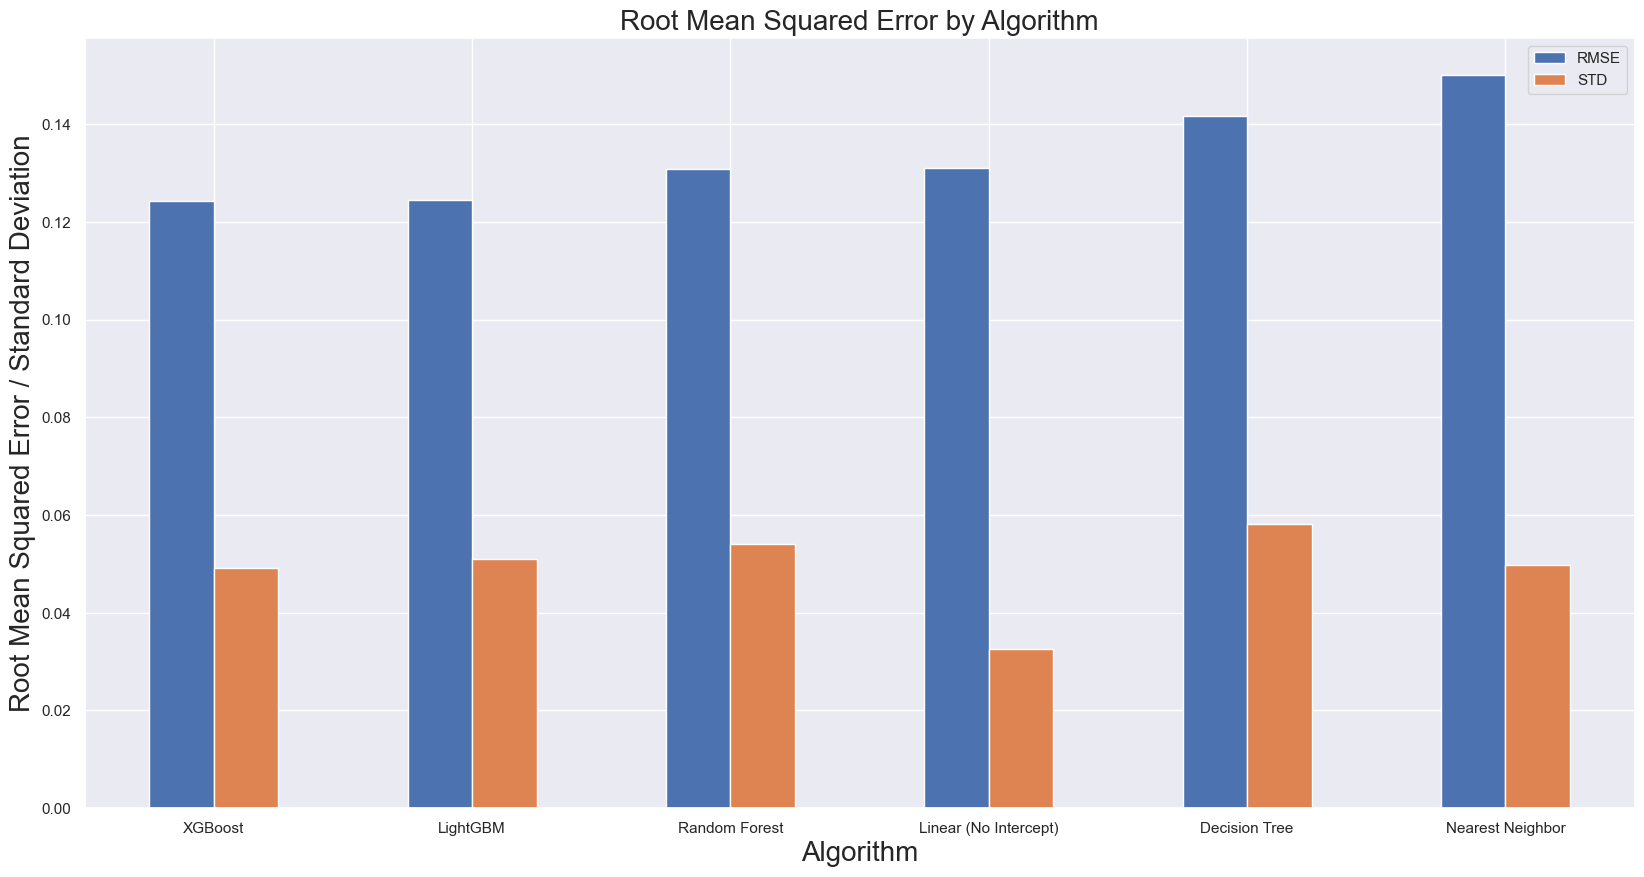

In [217]:
# creating the bar plot
data_df.plot(kind='bar',x = 'Algorithm', y = ['RMSE', 'STD'], figsize = (20,10), rot=0)
plt.xlabel("Algorithm",fontsize=20)
plt.ylabel("Root Mean Squared Error / Standard Deviation",fontsize=20)
plt.title("Root Mean Squared Error by Algorithm",fontsize=20)
plt.show()

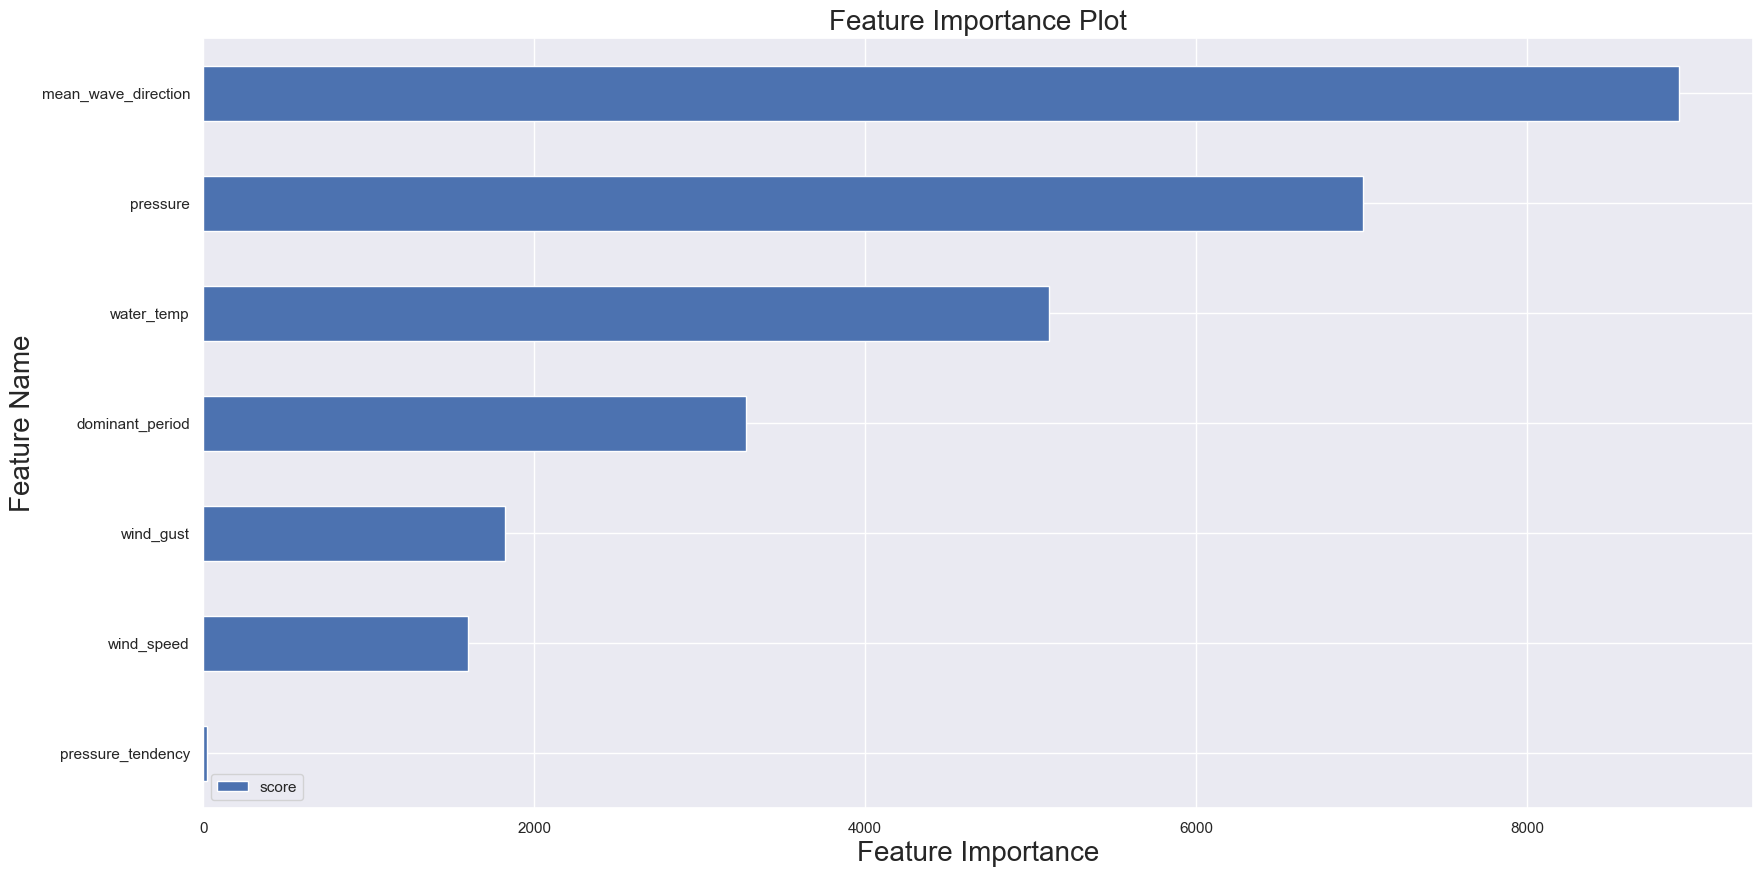

In [220]:
model = model_xgb.fit(train_df, ny_buoy.wave_height) #fit model on entire dataset to get variable importance since we fit it on each fold
feature_important = model.get_booster().get_score(importance_type='weight')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data[:20].plot(kind='barh', figsize = (20,10)).invert_yaxis(); ## plot top 20 features
plt.xlabel("Feature Importance",fontsize=20)
plt.ylabel("Feature Name",fontsize=20)
plt.title("Feature Importance Plot",fontsize=20)
plt.show()

## Repeat Training Models, but for Average Period

In [231]:
# Validation function for wave height
n_folds = 5

def rmse_cv_period(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse_period = np.sqrt(-cross_val_score(model, train_df, ny_buoy.average_period, scoring="neg_mean_squared_error", cv = kf))
    return rmse_period

In [232]:
score_linear = rmse_cv_period(lr_w_int,n_folds)
print("Linear Regression (w/ Intercept) score: {:.4f} ({:.4f})\n".format(score_linear.mean(), score_linear.std()))

Linear Regression (w/ Intercept) score: 0.1451 (0.0302)



In [233]:
score_linear_no_int = rmse_cv_period(lr_no_int,n_folds)
print("Linear Regression (No Intercept) score: {:.4f} ({:.4f})\n".format(score_linear_no_int.mean(), score_linear_no_int.std()))

Linear Regression (No Intercept) score: 0.1441 (0.0263)



In [234]:
score_neigh = rmse_cv_period(neigh,n_folds)
print("Nearest Neighbor (13) score: {:.4f} ({:.4f})\n".format(score_neigh.mean(), score_neigh.std()))

Nearest Neighbor (13) score: 0.1296 (0.0238)



In [235]:
score_dt = rmse_cv_period(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

Decision Tree Regression score: 0.1338 (0.0201)



In [236]:
score_rf = rmse_cv_period(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

Random Forest Regression score: 0.1124 (0.0153)



In [237]:
score_xg = rmse_cv_period(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

Xgboost score: 0.1045 (0.0105)



In [238]:
score_lgbm = rmse_cv_period(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

LGBM score: 0.1035 (0.0093)



In [239]:
# plot RMSE and STD for each Algorithm
data = {'Linear (No Intercept)':[score_linear_no_int.mean(),score_linear_no_int.std()], 'XGBoost':[score_xg.mean(),score_xg.std()], 'Random Forest': [score_rf.mean(),score_rf.std()]
        , 'LightGBM': [score_lgbm.mean(),score_lgbm.std()], 'Decision Tree': [score_dt.mean(),score_dt.std()],'Nearest Neighbor': [score_neigh.mean(),score_neigh.std()]}
data_df = pd.DataFrame(data=data).T.reset_index().sort_values(by = [0],ascending = True)
data_df.columns = ['Algorithm','RMSE','STD']

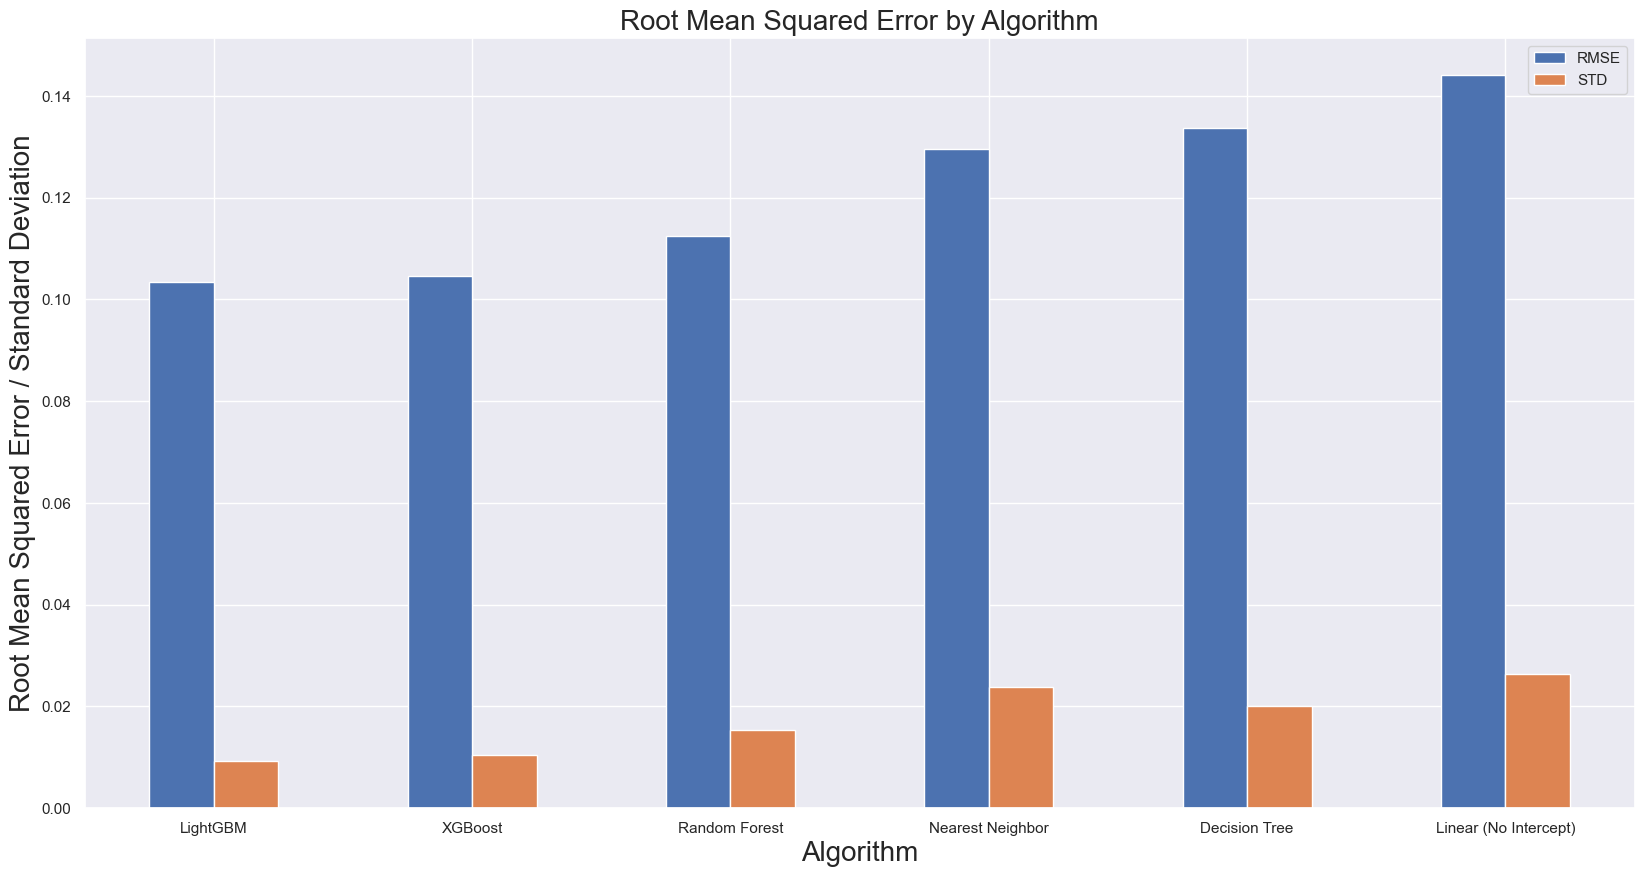

In [240]:
# creating the bar plot
data_df.plot(kind='bar',x = 'Algorithm', y = ['RMSE', 'STD'], figsize = (20,10), rot=0)
plt.xlabel("Algorithm",fontsize=20)
plt.ylabel("Root Mean Squared Error / Standard Deviation",fontsize=20)
plt.title("Root Mean Squared Error by Algorithm",fontsize=20)
plt.show()

<AxesSubplot:title={'center':'LightGBM Feature Importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

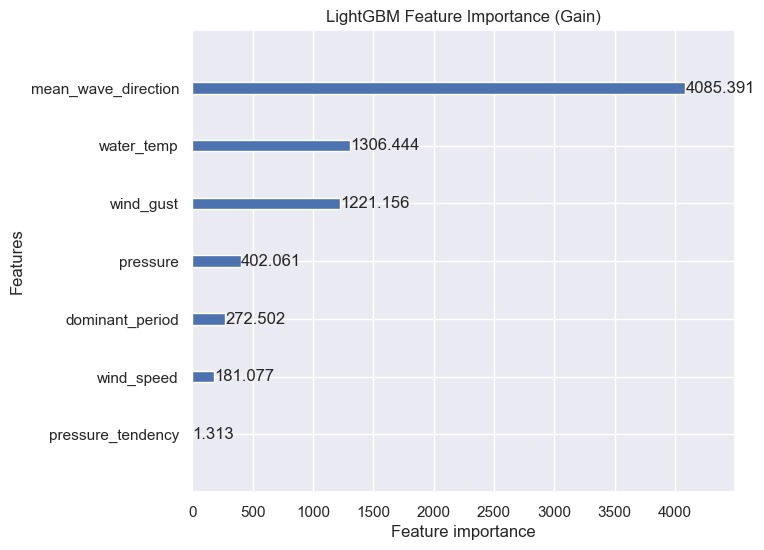

In [247]:
model = model_lgb.fit(train_df, ny_buoy.average_period) #fit model on entire dataset to get variable importance since we fit it on each fold
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")

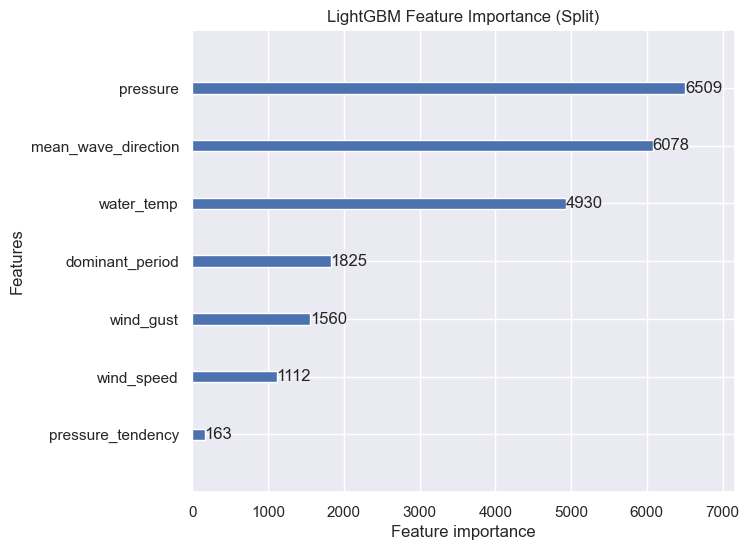

In [248]:
# Plot feature importance using Split
lgb.plot_importance(model, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()